In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from pycox.models import CoxCC

from pycox.evaluation import EvalSurv

import torch
import torchtuples as tt

# Read data

In [2]:
df_train = pd.read_csv('train.csv')
df_train = pd.DataFrame(df_train)

df_test = pd.read_csv('test.csv')
df_test = pd.DataFrame(df_test)

In [3]:
df_train.head()

,Sex,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage,duration,event
0,Male,41,65,Ileocecal Junction,II,29,1,T3,N1a,M0,IIIB,110,0
1,Male,54,95,Ascending Colon,II,37,0,T4a,N0,M0,IIB,107,0
2,Female,78,65,Sigmoid Colon,II,20,2,T4b,N1b,M0,IIIC,106,0
3,Female,33,150,"Large Intestine, NOS",II,9,0,T4a,N0,M0,IIB,105,0
4,Male,58,100,Descending Colon,III,6,1,T4a,N1a,M0,IIIB,102,0


In [4]:
# to label encoding categorical variables
le = LabelEncoder() #label encoder
cat_list = ['Sex','Site', 'Grade', 'T', 'N', 'M', 'Stage'] #list of categorical variables
for cat in cat_list:
    df_train[cat] = le.fit_transform(df_train[cat])
    df_test[cat] = le.fit_transform(df_test[cat])

df_train.head()

,Sex,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage,duration,event
0,1,41,65,3,1,29,1,2,2,0,7,110,0
1,1,54,95,0,1,37,0,4,0,0,3,107,0
2,0,78,65,7,1,20,2,5,3,0,8,106,0
3,0,33,150,4,1,9,0,4,0,0,3,105,0
4,1,58,100,1,2,6,1,4,2,0,7,102,0


In [5]:
# function to get targets variable
Y = lambda df_new: (df_new['duration'].values, df_new['event'].values)

# to standardize and get dependent variables 
x_num = ['Age', 'Size', 'Lymph.nodes.examined', 'Lymph.nodes.positive'] # list of variables for standardization
x_cat = ['Sex','Site', 'Grade', 'T', 'N', 'M', 'Stage'] #categorical variables 
standardize = [([num], StandardScaler()) for num in x_num]
label = [([cat], None) for cat in x_cat]

X_map = DataFrameMapper(standardize + label)

In [6]:
x_train = X_map.fit_transform(df_train).astype('float32') # x train
x_test= X_map.fit_transform(df_test).astype('float32') # x test
y_test = Y(df_test)
y_train = Y(df_train) # y train
time_test , status_test = Y(df_test) # test dependent variables Time & Status

# Neural Network

In [33]:
in_features = x_train.shape[1]
num_nodes = [16,2]
out_features = 1
batch_norm = True
dropout = 0.4
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size =64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

model_cox = CoxCC(net, tt.optim.Adam(lr=0.01,amsgrad=True)) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                        val_data =(x_test,y_test),  val_batch_size=batch_size)


0:	[0s / 0s],		train_loss: 0.8595,	val_loss: 0.6855
1:	[0s / 0s],		train_loss: 0.7413,	val_loss: 0.7161
2:	[0s / 0s],		train_loss: 0.6892,	val_loss: 0.6311
3:	[0s / 0s],		train_loss: 0.6787,	val_loss: 0.6561
4:	[0s / 0s],		train_loss: 0.6915,	val_loss: 0.6547
5:	[0s / 0s],		train_loss: 0.6402,	val_loss: 0.6649
6:	[0s / 0s],		train_loss: 0.6654,	val_loss: 0.6593
7:	[0s / 0s],		train_loss: 0.6810,	val_loss: 0.6583
8:	[0s / 0s],		train_loss: 0.6823,	val_loss: 0.6529
9:	[0s / 0s],		train_loss: 0.6895,	val_loss: 0.6486
10:	[0s / 0s],		train_loss: 0.6524,	val_loss: 0.6478
11:	[0s / 0s],		train_loss: 0.6534,	val_loss: 0.6755
12:	[0s / 0s],		train_loss: 0.6197,	val_loss: 0.6648
13:	[0s / 0s],		train_loss: 0.6325,	val_loss: 0.6453
14:	[0s / 0s],		train_loss: 0.6528,	val_loss: 0.6578
15:	[0s / 0s],		train_loss: 0.6361,	val_loss: 0.6527
16:	[0s / 0s],		train_loss: 0.6468,	val_loss: 0.6548
17:	[0s / 0s],		train_loss: 0.6418,	val_loss: 0.6746
18:	[0s / 0s],		train_loss: 0.6066,	val_loss: 0.6479
19:

0.6947152385838892

<Figure size 864x864 with 0 Axes>

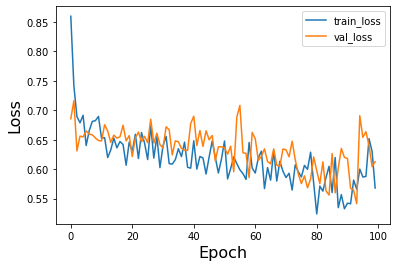

In [34]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, time_test, status_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.162876740612933

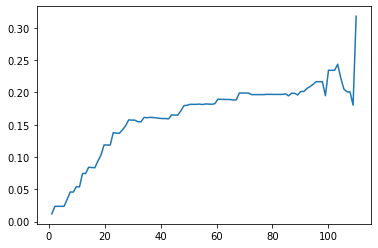

In [35]:
# extegrated_brier_score at all
time_grid = np.linspace(time_test.min(), time_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

# Internal validation

In [36]:
# c-index at  all
time_test0, status_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0, time_test0, status_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

0.7536603502653915

0.15664223570997518

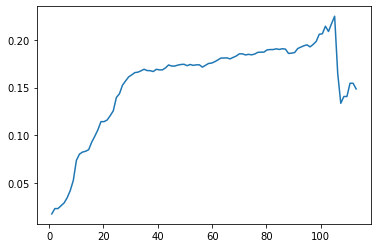

In [37]:
# brier score at all
time_grid0 = np.linspace(time_test0.min(), time_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

# Save

In [74]:
model_cox.save_model_weights('myweights_coxcc.pt')

# Bootstrap

In [39]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
model_cox.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.7554399685016681
The C-index Low 95% CI:0.7533468859962223
The C-index High 95% CI:0.7575330510071138


In [40]:
# External
ex_tem = []
model_cox.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.6984611740711923
The C-index Low 95% CI:0.6957345411421648
The C-index High 95% CI:0.7011878070002199


# LASSO var

In [41]:
df_train_lasso = df_train[["Age","Size","Site","Grade","Lymph.nodes.examined","Lymph.nodes.positive","T","N","M","Stage"]]
df_test_lasso = df_test[["Age","Size","Site","Grade","Lymph.nodes.examined","Lymph.nodes.positive","T","N","M","Stage"]]
df_train_lasso.head()

,Age,Size,Site,Grade,Lymph.nodes.examined,Lymph.nodes.positive,T,N,M,Stage
0,41,65,3,1,29,1,2,2,0,7
1,54,95,0,1,37,0,4,0,0,3
2,78,65,7,1,20,2,5,3,0,8
3,33,150,4,1,9,0,4,0,0,3
4,58,100,1,2,6,1,4,2,0,7


In [42]:
# to standardize and get dependent variables 
x_num = ['Age', 'Size', 'Lymph.nodes.examined', 'Lymph.nodes.positive'] # list of variables for standardization
x_cat = ['Site', 'Grade', 'T', 'N', 'M', 'Stage'] #categorical variables 
standardize = [([num], StandardScaler()) for num in x_num]
label = [([cat], None) for cat in x_cat]

X_map = DataFrameMapper(standardize + label)

x_train = X_map.fit_transform(df_train_lasso).astype('float32') # x train
x_test= X_map.fit_transform(df_test_lasso).astype('float32') # x test

In [46]:
in_features = x_train.shape[1]
num_nodes = [16,2]
out_features = 1
batch_norm = True
dropout = 0.4
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size = 64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

model_cox = CoxCC(net, tt.optim.Adam(lr=0.01,amsgrad=True)) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                        val_data =(x_test,y_test),  val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 0.9148,	val_loss: 0.7027
1:	[0s / 0s],		train_loss: 0.7732,	val_loss: 0.6694
2:	[0s / 0s],		train_loss: 0.7366,	val_loss: 0.6918
3:	[0s / 0s],		train_loss: 0.7750,	val_loss: 0.6681
4:	[0s / 0s],		train_loss: 0.8385,	val_loss: 0.6347
5:	[0s / 0s],		train_loss: 0.7209,	val_loss: 0.6734
6:	[0s / 0s],		train_loss: 0.7204,	val_loss: 0.6683
7:	[0s / 0s],		train_loss: 0.6944,	val_loss: 0.6732
8:	[0s / 0s],		train_loss: 0.6736,	val_loss: 0.6613
9:	[0s / 0s],		train_loss: 0.6574,	val_loss: 0.6806
10:	[0s / 0s],		train_loss: 0.7054,	val_loss: 0.6892
11:	[0s / 0s],		train_loss: 0.6884,	val_loss: 0.6623
12:	[0s / 0s],		train_loss: 0.7029,	val_loss: 0.6685
13:	[0s / 0s],		train_loss: 0.6697,	val_loss: 0.6901
14:	[0s / 0s],		train_loss: 0.6589,	val_loss: 0.6878
15:	[0s / 0s],		train_loss: 0.6558,	val_loss: 0.6637
16:	[0s / 0s],		train_loss: 0.6653,	val_loss: 0.6783
17:	[0s / 0s],		train_loss: 0.6412,	val_loss: 0.6589
18:	[0s / 0s],		train_loss: 0.6614,	val_loss: 0.6694
19:

0.6813750641354541

<Figure size 864x864 with 0 Axes>

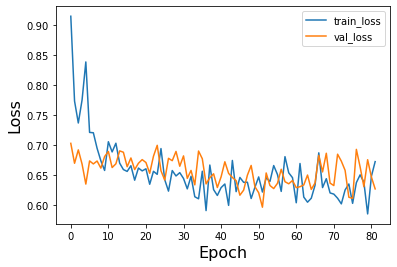

In [47]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, time_test, status_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.1737548965887529

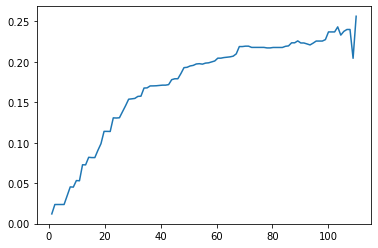

In [48]:
# extegrated_brier_score at all
time_grid = np.linspace(time_test.min(), time_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

In [49]:
# Internal:c-index at  all
time_test0, status_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0, time_test0, status_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

0.7079796917869688

0.17494122034084864

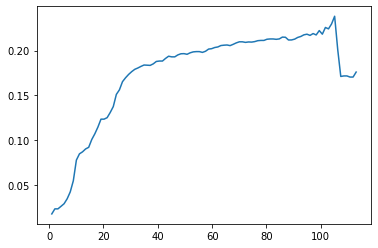

In [50]:
# brier score at all
time_grid0 = np.linspace(time_test0.min(), time_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

bootstrap

In [51]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
model_cox.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))


Bootstrap Internal validation:
The C-index:0.7090384549420671
The C-index Low 95% CI:0.7066956339606889
The C-index High 95% CI:0.7113812759234452


In [52]:
# External
ex_tem = []
model_cox.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))


Bootstrap External validation:
The C-index:0.6846992435565932
The C-index Low 95% CI:0.681781760616736
The C-index High 95% CI:0.6876167264964503


# TNM

In [53]:
df_train_tnm = df_train[["T","N","M","Stage"]]
df_test_tnm = df_test[["T","N","M","Stage"]]
df_train_tnm.head()

,T,N,M,Stage
0,2,2,0,7
1,4,0,0,3
2,5,3,0,8
3,4,0,0,3
4,4,2,0,7


In [54]:
# to standardize and get dependent variables 
x_cat = ['T', 'N', 'M', 'Stage'] #categorical variables 
label = [([cat], None) for cat in x_cat]

X_map = DataFrameMapper(label)

x_train = X_map.fit_transform(df_train_tnm).astype('float32') # x train
x_test= X_map.fit_transform(df_test_tnm).astype('float32') # x test

In [67]:
in_features = x_train.shape[1]
num_nodes = [16,4]
out_features = 1
batch_norm = True
dropout = 0.4
output_bias = False
epochs = 100
callbacks = [tt.callbacks.EarlyStopping(patience=30)]
#callbacks = None
verbose = True
batch_size = 64

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm,
                              dropout, output_bias=output_bias)

model_cox = CoxCC(net, tt.optim.Adam(lr=0.01,amsgrad=True)) #cox model on the neural network with Adam optimizer

log_cox = model_cox.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                        val_data =(x_test,y_test),  val_batch_size=batch_size)

0:	[0s / 0s],		train_loss: 0.8345,	val_loss: 0.8064
1:	[0s / 0s],		train_loss: 0.8021,	val_loss: 0.7245
2:	[0s / 0s],		train_loss: 0.7834,	val_loss: 0.6769
3:	[0s / 0s],		train_loss: 0.7763,	val_loss: 0.6666
4:	[0s / 0s],		train_loss: 0.7272,	val_loss: 0.6479
5:	[0s / 0s],		train_loss: 0.7060,	val_loss: 0.6691
6:	[0s / 0s],		train_loss: 0.7080,	val_loss: 0.6329
7:	[0s / 0s],		train_loss: 0.6761,	val_loss: 0.6691
8:	[0s / 0s],		train_loss: 0.6539,	val_loss: 0.6493
9:	[0s / 0s],		train_loss: 0.6508,	val_loss: 0.6704
10:	[0s / 0s],		train_loss: 0.6756,	val_loss: 0.6524
11:	[0s / 0s],		train_loss: 0.6563,	val_loss: 0.6888
12:	[0s / 0s],		train_loss: 0.6478,	val_loss: 0.6633
13:	[0s / 0s],		train_loss: 0.6534,	val_loss: 0.6730
14:	[0s / 0s],		train_loss: 0.6182,	val_loss: 0.6411
15:	[0s / 0s],		train_loss: 0.6629,	val_loss: 0.6587
16:	[0s / 0s],		train_loss: 0.6581,	val_loss: 0.6563
17:	[0s / 0s],		train_loss: 0.6375,	val_loss: 0.6528
18:	[0s / 0s],		train_loss: 0.6566,	val_loss: 0.6599
19:

0.6754746023601848

<Figure size 864x864 with 0 Axes>

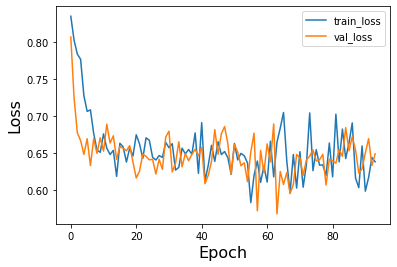

In [68]:
#plotting the loss vs epoch 
plt.figure(figsize=[12,12])
log_cox.plot()
plt.xlabel('Epoch', fontsize = 16)
plt.ylabel('Loss', fontsize = 16)

# predict for the cox model(external validation)
model_cox.compute_baseline_hazards() #baseline hazard
surv_cox = model_cox.predict_surv_df(x_test) # survival of the test data
# evaluate the c-index of the cox model 
eval_cox = EvalSurv(surv_cox, time_test, status_test, censor_surv= 'km')
cox_index = eval_cox.concordance_td() 
cox_index  # cox_index  at all

0.17679068940753598

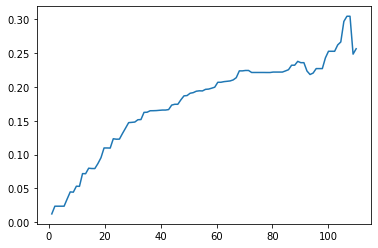

In [69]:
# extegrated_brier_score at all
time_grid = np.linspace(time_test.min(), time_test.max(), 100)
_ = eval_cox.brier_score(time_grid).plot()
eval_cox.integrated_brier_score(time_grid)

In [70]:
# Internal:c-index at  all
time_test0, status_test0 = y_train 
surv_cox0 = model_cox.predict_surv_df(x_train) # survival of the test data
eval_cox0 = EvalSurv(surv_cox0, time_test0, status_test0, censor_surv= 'km')
cox_index0 = eval_cox0.concordance_td() 
cox_index0 

0.6663888817661991

0.18565969798446566

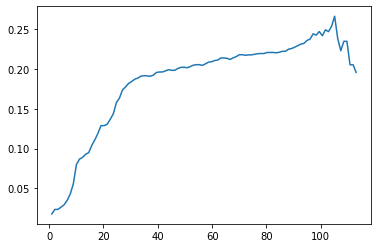

In [71]:
# brier score at all
time_grid0 = np.linspace(time_test0.min(), time_test0.max(), 100)
_ = eval_cox0.brier_score(time_grid0).plot()
eval_cox0.integrated_brier_score(time_grid0)

In [72]:
# Internal
# ATTENTION :x_train, y_train is numpy.ndarray
in_tem = []
model_cox.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_train),size = 100,replace = True)
    x_tem = x_train[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_train[0][idx], y_train[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    in_tem.append(c_tem)

in_mean = np.mean(in_tem)
in_se = np.std(in_tem) / np.power(1000,0.5)
print("Bootstrap Internal validation:")
print("The C-index:{}".format(in_mean))
print("The C-index Low 95% CI:{}".format(in_mean - 1.96 * in_se))
print("The C-index High 95% CI:{}".format(in_mean + 1.96 * in_se))

Bootstrap Internal validation:
The C-index:0.6677009481370457
The C-index Low 95% CI:0.6651744905305265
The C-index High 95% CI:0.670227405743565


In [73]:
# External
ex_tem = []
model_cox.compute_baseline_hazards()
for i in range(1000):
    idx = np.random.choice(len(x_test),size = 100,replace = True)
    x_tem = x_test[idx,]
    surv_cox_tem = model_cox.predict_surv_df(x_tem) # survival of the test data
    eval_cox_tem = EvalSurv(surv_cox_tem, y_test[0][idx], y_test[1][idx], censor_surv= 'km')
    c_tem = eval_cox_tem.concordance_td() 
    ex_tem.append(c_tem)

ex_mean = np.mean(ex_tem)
ex_se = np.std(ex_tem) / np.power(1000,0.5)
print("Bootstrap External validation:")
print("The C-index:{}".format(ex_mean))
print("The C-index Low 95% CI:{}".format(ex_mean - 1.96 * ex_se))
print("The C-index High 95% CI:{}".format(ex_mean + 1.96 * ex_se))

Bootstrap External validation:
The C-index:0.6785462272731215
The C-index Low 95% CI:0.6758036216599322
The C-index High 95% CI:0.6812888328863108
